In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from nilearn.plotting import plot_design_matrix, plot_stat_map, view_img
from nilearn.reporting import get_clusters_table
from nilearn import datasets
import glob
import os
import numpy as np
import pandas as pd

import sys
sys.path.append('/Users/zeynepenkavi/Documents/RangelLab/DescribedVsLearned_fmri/analysis/03_level3')
from make_design_files import make_design_files

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
def get_filt_tval_img(reg, mnum = "1", tstat="1",threshold=0.95):
    
    level3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/model%s'%(mnum)
    
    pos_pval_fn = '%s/rand_model%s_%s_tfce_corrp_tstat%s.nii.gz'%(reg, mnum, reg, tstat)
    neg_pval_fn = '%s/rand_model%s_%s_tfce_corrp_tstat%s.nii.gz'%(reg, mnum, 'neg_'+reg, tstat)
    tval_fn = '%s/rand_model%s_%s_tstat%s_tfce.nii.gz'%(reg, mnum, reg, tstat)
    
    pos_pval_img = os.path.join(level3_path, pos_pval_fn)
    neg_pval_img = os.path.join(level3_path, neg_pval_fn)
    tval_img = os.path.join(level3_path, tval_fn)
    
    pos_pval_img = nib.load(pos_pval_img)
    neg_pval_img = nib.load(neg_pval_img)
    tval_img = nib.load(tval_img)
    
    tval_data = tval_img.get_fdata()
    pos_pval_data = pos_pval_img.get_fdata()
    neg_pval_data = neg_pval_img.get_fdata()
    
    filt_tval_data = np.where(pos_pval_data > threshold, tval_data, np.where(neg_pval_data > threshold, tval_data, 0))
    filt_tval_img = nib.Nifti1Image(filt_tval_data.astype(np.float64), tval_img.affine)
    
    return filt_tval_img

def plot_filt_tval_img(reg, mnum = "1", tstat="1", threshold=0.95, interactive=False):
    filt_tval_img = get_filt_tval_img(reg, mnum = mnum, tstat=tstat, threshold=threshold)
    if(len(np.unique(filt_tval_img.get_fdata())) == 1):
        print('Nothing survives correction for %s, model = %s, tstat = %s'%(reg, mnum, tstat))
    elif interactive:
        view = view_img(filt_tval_img, 
             draw_cross=False,
             title='%s'%(reg))
        
        return view
    else:
        print('Plotting tvalues filtered for corrected p values > 0.05')
        plot_stat_map(filt_tval_img, 
             draw_cross=False,
             title='%s'%(reg))

# RT modeling difference

Pertains to cross, valChosen, valUnchosen, conflict, noconflict **DEBUGGED - waiting on L3**

# Event regressors

Change in activity when fractal probabilities are presented

Plotting tvalues filtered for corrected p values > 0.05


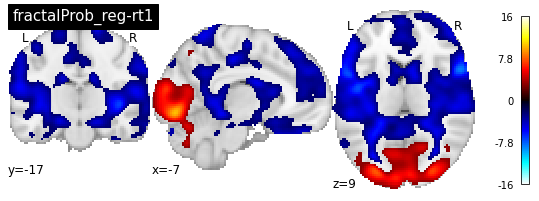

In [3]:
reg = 'fractalProb_reg-rt1'
plot_filt_tval_img(reg)

Change in activity when stimuli are presented

Plotting tvalues filtered for corrected p values > 0.05


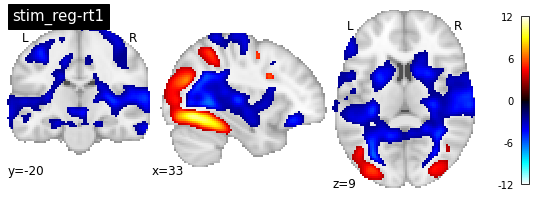

In [4]:
reg = 'stim_reg-rt1'
plot_filt_tval_img(reg)

Plotting tvalues filtered for corrected p values > 0.05


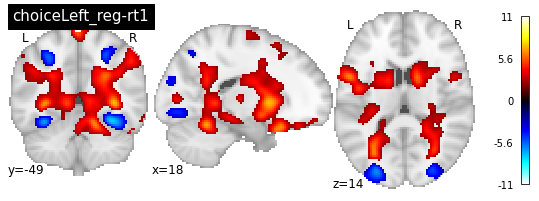

In [5]:
reg = 'choiceLeft_reg-rt1'
plot_filt_tval_img(reg)

Plotting tvalues filtered for corrected p values > 0.05


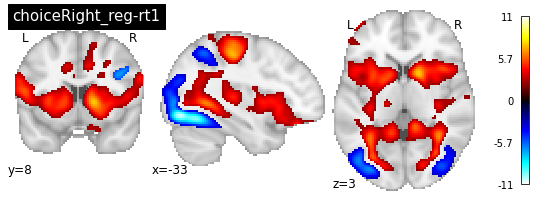

In [6]:
reg = 'choiceRight_reg-rt1'
plot_filt_tval_img(reg)

Change in activity when reward is presented

Plotting tvalues filtered for corrected p values > 0.05


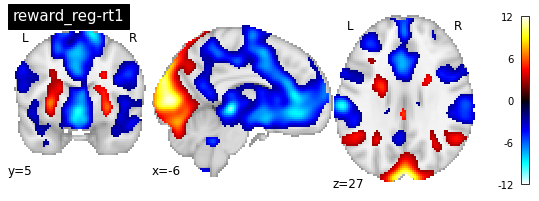

In [7]:
reg = 'reward_reg-rt1'
plot_filt_tval_img(reg)

# Parametric regressors

Plotting tvalues filtered for corrected p values > 0.05


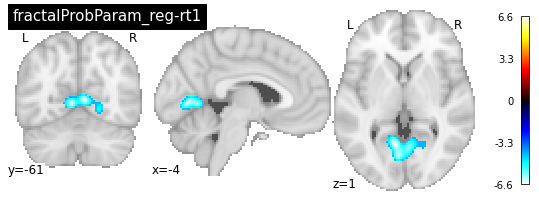

In [8]:
reg = 'fractalProbParam_reg-rt1'
plot_filt_tval_img(reg)

Plotting tvalues filtered for corrected p values > 0.05


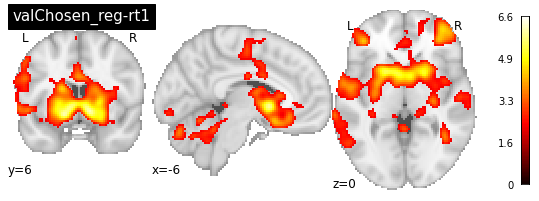

In [9]:
reg = 'valChosen_reg-rt1'
plot_filt_tval_img(reg)

Plotting tvalues filtered for corrected p values > 0.05


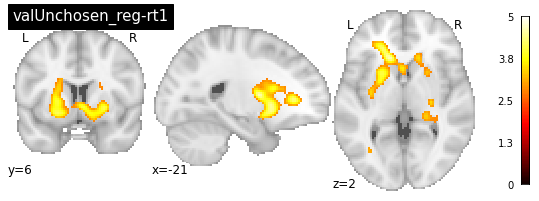

In [10]:
reg = 'valUnchosen_reg-rt1'
plot_filt_tval_img(reg)

RPE is capturing too much. Will add parametric reward regressor back in.

Plotting tvalues filtered for corrected p values > 0.05


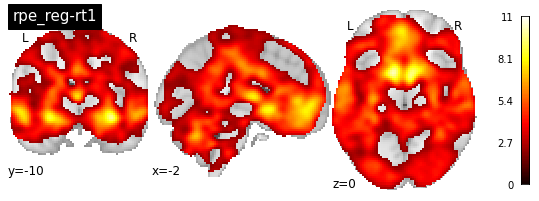

In [11]:
reg = 'rpe_reg-rt1'
plot_filt_tval_img(reg)

# Conflict vs no conflict

Modeled separately and stim is the sum of these two so the collinearity in the level 1 design matrix is fixed.

Plotting tvalues filtered for corrected p values > 0.05


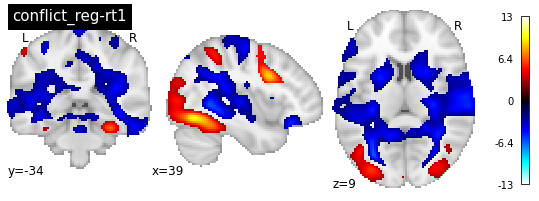

In [12]:
reg = 'conflict_reg-rt1'
plot_filt_tval_img(reg)

Plotting tvalues filtered for corrected p values > 0.05


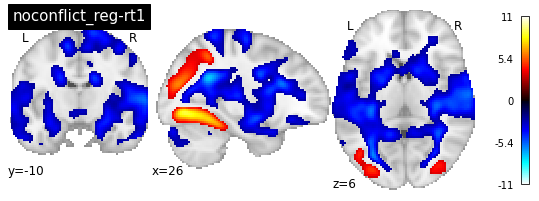

In [13]:
reg = 'noconflict_reg-rt1'
plot_filt_tval_img(reg)

In [14]:
reg = 'conflict-gt-noconflict_reg-rt1'
plot_filt_tval_img(reg)

Nothing survives correction for conflict-gt-noconflict_reg-rt1, model = 1, tstat = 1


In [15]:
reg = 'noconflict-gt-conflict_reg-rt1'
plot_filt_tval_img(reg)

Nothing survives correction for noconflict-gt-conflict_reg-rt1, model = 1, tstat = 1


# Slow vs fast learner

tstat1 = fast learner > slow learner  
tstat2 = slow learner > fast learner

In [16]:
regs = ['choiceLeft_reg-rt0', 'choiceRight_reg-rt0', 'conflict_reg-rt0', 'conflict-gt-noconflict_reg-rt0', 'cross_reg-rt0', 'fractalProb_reg-rt0', 'fractalProbParam_reg-rt0', 'noconflict_reg-rt0', 'noconflict-gt-conflict_reg-rt0','reward_reg-rt0','rpe_reg-rt0', 'stim_reg-rt0','task-on_reg-rt0', 'valChosen_reg-rt0', 'valUnchosen_reg-rt0']
tstats = ["1", "2"]

for reg in regs:
    for tstat in tstats:
        plot_filt_tval_img(reg, mnum, tstat)

NameError: name 'mnum' is not defined

# Interactions with p(Fractal)

Does processing of ... change depending on p(Fractal)?